In [1]:
from helpfiles import *
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure, draw, pause
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output
import functools

In [127]:
def random_forest(width, height, vegetation_ratio=0.5, boulders=0, bouldersize=20):
    map_matrix = np.zeros((height, width))
    
    water = 0
    land = 1
    vegetation = 2
    
    for i in range(height):
        for j in range(width):
            
            # 2 tiles water padding
            if i < 2 or i > height - 3 or j < 2 or j > width - 3:
                map_matrix[i][j] = water

            # set initial vegetation
            elif random.random() < vegetation_ratio:
                map_matrix[i][j] = vegetation
            
            # set land
            else:
                map_matrix[i][j] = land
    
    for i in range(boulders):
        starting_point = [random.randint(0, height), random.randint(0, width)]
        
        for j in range(bouldersize):
            for k in range(bouldersize):
                map_matrix[(starting_point[0] + j) % height][(starting_point[1] + k) % width] = 1
        
    return map_matrix


def wind_matrix(degrees, multiplier=1):

    degrees = degrees % 360
    
    mirror = False
    if degrees > 180:
        mirror = True
        degrees -= 180
    
    n_diff = min(abs(360 - degrees), abs(360 - (degrees + 360))) / 180
    s_diff = min(abs(180 - degrees), abs(180 - (degrees + 360))) / 180
    w_diff = min(abs(270 - degrees), abs(270 - (degrees + 360))) / 180
    e_diff = min(abs(90  - degrees), abs(90  - (degrees + 360))) / 180
    
    nw_diff = min(abs(315 - degrees), abs(315 - (degrees + 360))) / 180
    sw_diff = min(abs(225 - degrees), abs(225 - (degrees + 360))) / 180
    se_diff = min(abs(135 - degrees), abs(135 - (degrees + 360))) / 180
    ne_diff = min(abs(45  - degrees), abs(45  - (degrees + 360))) / 180
    
    wind_matrix = np.zeros((3,3))
    wind_matrix[1, 1] = 1
    
    wind_matrix[0, 1] = (1 + (n_diff - .5)) ** multiplier
    wind_matrix[2, 1] = (1 + (s_diff - .5)) ** multiplier
    wind_matrix[1, 0] = (1 + (w_diff - .5)) ** multiplier
    wind_matrix[1, 2] = (1 + (e_diff - .5)) ** multiplier
    
    wind_matrix[0, 0] = (1 + (nw_diff - .5)) ** multiplier
    wind_matrix[2, 0] = (1 + (sw_diff - .5)) ** multiplier
    wind_matrix[2, 2] = (1 + (se_diff - .5)) ** multiplier
    wind_matrix[0, 2] = (1 + (ne_diff - .5)) ** multiplier
    
    if mirror:
        wind_matrix = np.flip(np.flip(wind_matrix, 0), 1)
        
    return wind_matrix

wind_matrix(90, 5)

array([[3.05175781, 1.        , 0.23730469],
       [7.59375   , 1.        , 0.03125   ],
       [3.05175781, 1.        , 0.23730469]])

In [128]:
class ForestFires:
    def __init__(self, map_matrix, init_burning_ratio, wind_dir, wind_speed,
                 p_spread=0.4, p_medium=0.3, p_intense=0.2, p_ash=0.2):
        self.map_matrix = map_matrix
        self.init_burning_ratio = init_burning_ratio
        
        self.p_spread = p_spread
        self.p_medium = p_medium
        self.p_intense = p_intense
        self.p_ash = p_ash
        
        
        # relative coordinates of 3x3 neighbourhood kernel
        self.neigh_dirs = np.array([[(-1,-1), 0.83], [(-1,0),1], [(-1,1), 0.83],
                                    [(0,-1),1], [(0,1),1],
                                    [(1,-1), 0.83], [(1,0),1], [(1,1), 0.83]])

        # 3x3 kernels that influence the bruning_ratio of fire
        self.wind_matrix = wind_matrix(wind_dir, wind_speed)  
        
        # init dictionary containing vegetation population
        self.veg_population = self.set_vegetation_population(self.map_matrix)
        
    def set_vegetation_population(self, map_matrix):
        veg_population = {}
        map_mat = map_matrix
        
        rand = random.random
        for (y,x) in np.argwhere(map_mat == 2):
                    
                # initial propability of vegetation burning
                if rand() < self.init_burning_ratio:
                    veg_population[(x,y)] = Vegetation(0, 1)

                else:
                    veg_population[(x,y)] = Vegetation(4, 1)
                    
        return veg_population

        

    def update(self):
        # create a temporary dict to safely replace values in the veg_population dict later on 

        # 
        randnum = random.random
        p_spread = self.p_spread
        p_medium = self.p_medium
        p_intense = self.p_intense
        p_ash = self.p_ash
        
        # assign class attributes to local variables for improved lookup speed
        current_population = self.veg_population.copy()
        temp_population = {}
        map_matrix = self.map_matrix
        neigh_dirs = self.neigh_dirs
        wind_matrix = self.wind_matrix
        
        for (x,y) in current_population:
            # if current vegetation is not burned up already
            if current_population[(x,y)].status == 4:
                
                # fill 3x3 neighbourhood kernel
                for ((dy, dx), multiplier) in neigh_dirs:
                    y1 = y + dy
                    x1 = x + dx
#                     print()
#                     print(f'current coords = {y},{x}')
#                     print(f'neigh coords = {y1},{x1}')
#                     print(f'wind index = {dy+1,dx+1}')
#                     print(f'wind value = {wind_matrix[dy+1,dx+1]}')

                    if (x1,y1) in current_population and current_population[(x1,y1)].status == 0:
                            if randnum() < (p_spread * wind_matrix[dy+1,dx+1] * multiplier):
                                temp_population[(x,y)] = Vegetation(0,1)  
                                continue
                        
            elif current_population[(x,y)].status == 0:
                if randnum() < p_medium:
                    temp_population[(x,y)] = Vegetation(1,1)
                    
            elif current_population[(x,y)].status == 1:
                if randnum() < p_intense:
                    temp_population[(x,y)] = Vegetation(2,1)

            elif current_population[(x,y)].status == 2:
                if randnum() < p_ash:
                    temp_population[(x,y)] = Vegetation(3,1)
            
        for (x,y) in temp_population:
            current_population[(x,y)] = temp_population[(x,y)]
        
        self.veg_population = current_population.copy()
        
    def visualize(self, timestep, runtime):
        current_map = self.map_matrix.copy()
        current_population = self.veg_population.copy()
        
        # update burned_ratio with gradations if they are present in matrix
        for (x,y) in current_population:
            status = current_population[(x,y)].status

            if status == 0:
                current_map[y][x] = 3

            # start stage of fire
            elif status == 1:
                current_map[y][x] = 4
                
            # mid stage of fire
            elif status == 2:
                current_map[y][x] = 5

            # last stage of fire
            elif status == 3:
                current_map[y][x] = 8
        
        colorMap = ['midnightblue', 'lightgrey', 'darkgreen', 'yellow', 'orange', 'red',  'olivedrab', 'darkolivegreen', 'black']
        indices, colors = list(zip(*[(i, c) for i,c in enumerate(colorMap) if i in current_map]))
        
        norm = plt.Normalize(min(indices), max(indices))
        tuples = list(zip(map(norm, indices), colors))
        cmap = LinearSegmentedColormap.from_list("", tuples)
 

        # plot current state of matrix
        figure(num=None, figsize=(15, 15))
        plt.title(f"Timestep = {timestep}\nFrame runtime = {runtime}")
        plt.imshow(current_map, cmap=cmap, norm=norm)
        plt.show()
        clear_output(wait=True)
    
        
class Vegetation:
    def __init__(self, status, height):
    
        # burning or neutral
        self.status = status
        self.height = height

In [129]:
def forest_fire_simulation(iterations, height, width, wind_dir, wind_speed, rand_forest=False,
                           vegetation_ratio=0.5, init_burning_ratio=0.05):
    map_array = None
    
    if rand_forest:
        map_array = random_forest(width, height, vegetation_ratio, boulders=0, bouldersize=20)
    else:
        map_array = generate_map_australia(width, height)

    forest_sim = ForestFires(map_array, init_burning_ratio, wind_dir, wind_speed)

    iterations = iterations
    t = time.time
    prev_runtime = 0
    for i in range(iterations):
        t1 = t()
        forest_sim.update()
        forest_sim.visualize(i, prev_runtime)
        t2 = t()
        prev_runtime = t2-t1

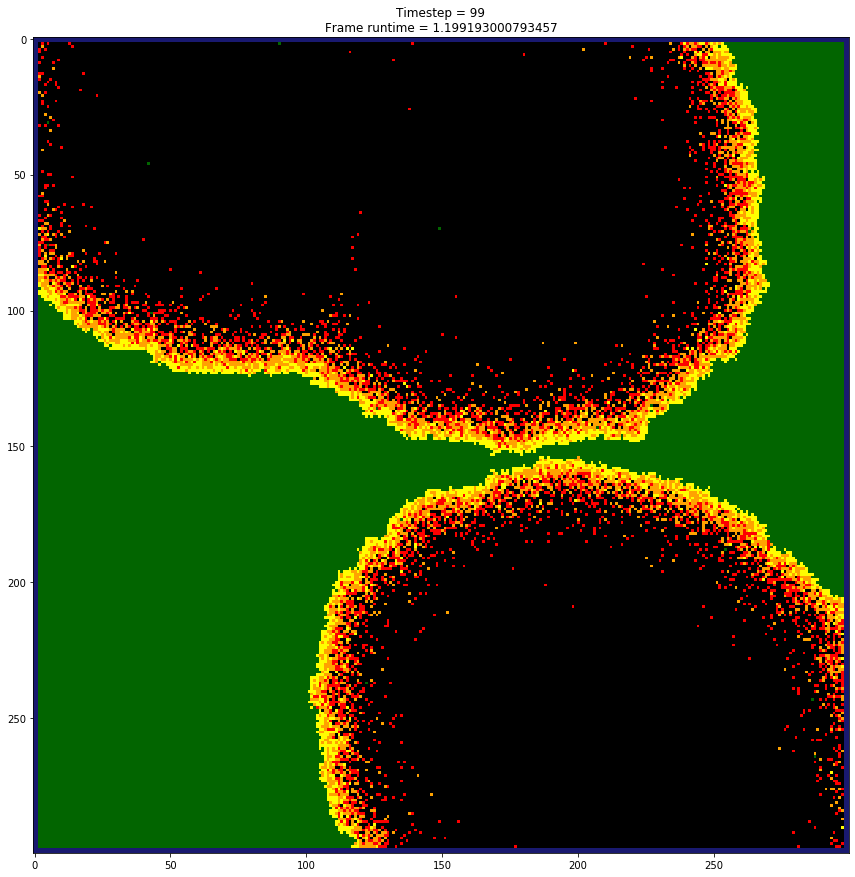

In [140]:
iterations = 100
width = 300
height = 300
vegetation_ratio = 1
init_burning_ratio = 0.00005
init_ratio_burned = 0.8
wind_dir = 180
wind_speed = 0
rand_forest=True

forest_fire_simulation(iterations, height, width, wind_dir, wind_speed, rand_forest=rand_forest,
                       vegetation_ratio=vegetation_ratio, init_burning_ratio=init_burning_ratio)

In [34]:
wind = wind_matrix(180,5)
wind

array([[0. , 1.5, 0. ],
       [1. , 1. , 1. ],
       [0. , 0.5, 0. ]])

In [99]:
neigh_dirs = np.array([[-1,0],[0,-1], [0,1], [1,0]])

x,y = 2,2

for (dy,dx) in neigh_dirs:
    y1 = y+dy
    x1 = x+dx
    print(f'current coords= {y},{x}')
    print(f'neigh coords = {y1,x1}')
    print(f'wind index = {dy+1,dx+1}')
    print(f'wind value = {wind[dy+1,dx+1]}')
    print()
#     print(wind[y+1,x+1])

current coords= 2,2
neigh coords = (1, 2)
wind index = (0, 1)
wind value = 1.5

current coords= 2,2
neigh coords = (2, 1)
wind index = (1, 0)
wind value = 1.0

current coords= 2,2
neigh coords = (2, 3)
wind index = (1, 2)
wind value = 1.0

current coords= 2,2
neigh coords = (3, 2)
wind index = (2, 1)
wind value = 0.5



In [137]:
wind_matrix(0,2)

array([[0.5625, 0.25  , 0.5625],
       [1.    , 1.    , 1.    ],
       [1.5625, 2.25  , 1.5625]])